# Host vs. Device vs. Global

In [1]:
import numba
from numba import cuda
import numpy as np

#no decorator = host function. Normal python function which runs on the CPU
def host_func():
    #create a numpy array of integers, x_host
    x_host = np.zeros(100, dtype=int)

    #create a copy of x_host on the GPU. This copy is in device memory, and cannot be directly accessed by the CPU
    x_device = cuda.to_device(x_host)

    #here, we call the global function, from the CPU, to be executed on the GPU. We pass the device array, x_device, to this function running on the GPU
    #note the bracket notation, where we tell the GPU how many threads, and how many blocks of threads, to use
    thread_blocks = 256
    threads_per_block = 256
    global_func[thread_blocks, threads_per_block](x_device)

    #finally, copy the results, which have ben stored in x_device, back to x_host
    x_device.copy_to_host(x_host)

    #print the results (on the CPU!)
    print(x_host)

#this decorator tells numba to rewrite this python function as a global function to be run on the GPU, whenever it's called by the CPU
@cuda.jit()
def global_func(x):
    thread_id = cuda.grid(1)
    num_threads = cuda.gridsize(1)

    #this for loop ensures each thread only works on part of the array, thread 0 works on array index 0, thread 1 works on array index 1, etc.
    #extra threads may go unused, which is completely ok other than being a little inefficient
    #if the array was larger than num_threads, threads would run on more than one index, due to the stride being equal to num_threads
    #e.g. if num_threads = 16, thread 0 would work on array indices 0, 16, 32, 48, 64, 80, and 96 for this array of size 100
    for i in range(thread_id, x.shape[0], num_threads):
        x[i] += device_func(i)

#this decorator, slightly different than the previous one, defines this function as a device function,
#    which may only be called on the GPU (by a global function, or another device function)
@cuda.jit(device=True)
def device_func(value):
    return value*value 

In [2]:
host_func()

[   0    1    4    9   16   25   36   49   64   81  100  121  144  169
  196  225  256  289  324  361  400  441  484  529  576  625  676  729
  784  841  900  961 1024 1089 1156 1225 1296 1369 1444 1521 1600 1681
 1764 1849 1936 2025 2116 2209 2304 2401 2500 2601 2704 2809 2916 3025
 3136 3249 3364 3481 3600 3721 3844 3969 4096 4225 4356 4489 4624 4761
 4900 5041 5184 5329 5476 5625 5776 5929 6084 6241 6400 6561 6724 6889
 7056 7225 7396 7569 7744 7921 8100 8281 8464 8649 8836 9025 9216 9409
 9604 9801]


In [7]:
import cupy as cp
from cupyx import jit
import numpy as np

#no decorator = host function. Normal python function which runs on the CPU
def host_func():
    #create a numpy array of integers, x_host
    x_host = np.zeros(100, dtype=int)

    #create a copy of x_host on the GPU. This copy is in device memory, and cannot be directly accessed by the CPU
    x_device = cp.array(x_host)

    #here, we call the global function, from the CPU, to be executed on the GPU. We pass the device array, x_device, to this function running on the GPU
    #note the bracket notation, where we tell the GPU how many threads, and how many blocks of threads, to use
    thread_blocks = 256
    threads_per_block = 256
    global_func[thread_blocks, threads_per_block](x_device)

    #finally, copy the results, which have ben stored in x_device, back to x_host
    x_host = x_device.get()

    #print the results (on the CPU!)
    print(x_host)

#this decorator tells numba to rewrite this python function as a global function to be run on the GPU, whenever it's called by the CPU
@jit.rawkernel()
def global_func(x):
    thread_id = jit.grid(1)
    num_threads = jit.gridsize(1)

    #this for loop ensures each thread only works on part of the array, thread 0 works on array index 0, thread 1 works on array index 1, etc.
    #extra threads may go unused, which is completely ok other than being a little inefficient
    #if the array was larger than num_threads, threads would run on more than one index, due to the stride being equal to num_threads
    #e.g. if num_threads = 16, thread 0 would work on array indices 0, 16, 32, 48, 64, 80, and 96 for this array of size 100
    for i in range(thread_id, x.shape[0], num_threads):
        x[i] += device_func(i)

#this decorator, slightly different than the previous one, defines this function as a device function,
#    which may only be called on the GPU (by a global function, or another device function)
@jit.rawkernel(device=True)
def device_func(value):
    return value*value

In [8]:
host_func()

[   0    1    4    9   16   25   36   49   64   81  100  121  144  169
  196  225  256  289  324  361  400  441  484  529  576  625  676  729
  784  841  900  961 1024 1089 1156 1225 1296 1369 1444 1521 1600 1681
 1764 1849 1936 2025 2116 2209 2304 2401 2500 2601 2704 2809 2916 3025
 3136 3249 3364 3481 3600 3721 3844 3969 4096 4225 4356 4489 4624 4761
 4900 5041 5184 5329 5476 5625 5776 5929 6084 6241 6400 6561 6724 6889
 7056 7225 7396 7569 7744 7921 8100 8281 8464 8649 8836 9025 9216 9409
 9604 9801]


# Detailed breakdown of the for loop - parallelizing the problem

In [4]:
# print each of the ranges mentioned in the section. Convert each range to a list to print the actual values!

#ranges are in the format "range(thread_id, num_tasks, num_threads)"
#two cases of interest, where num_tasks >= num_threads, and where num_tasks < num_threads

#First, the ranges when num_tasks is at least as big as num_threads
print("Case 1: num_tasks >= num_threads")
print(f"range(0, 8, 4) = {list(range(0, 8, 4))}")
print(f"range(1, 8, 4) = {list(range(1, 8, 4))}")
print(f"range(2, 8, 4) = {list(range(2, 8, 4))}")
print(f"range(3, 8, 4) = {list(range(3, 8, 4))}")
print("")

#Second, the ranges when num_tasks is smaller than num_threads
print("Case 3: num_tasks < num_threads")
print(f"range(0, 8, 100) = {list(range(0, 8, 100))}")
print(f"range(1, 8, 100) = {list(range(1, 8, 100))}")
print("...")
print(f"range(7, 8, 100) = {list(range(7, 8, 100))}")
print(f"range(8, 8, 100) = {list(range(8, 8, 100))}")
print(f"range(9, 8, 100) = {list(range(9, 8, 100))}")
print("...")
print(f"range(99, 8, 100) = {list(range(99, 8, 100))}")

Case 1: num_tasks >= num_threads
range(0, 8, 4) = [0, 4]
range(1, 8, 4) = [1, 5]
range(2, 8, 4) = [2, 6]
range(3, 8, 4) = [3, 7]

Case 3: num_tasks < num_threads
range(0, 8, 100) = [0]
range(1, 8, 100) = [1]
...
range(7, 8, 100) = [7]
range(8, 8, 100) = []
range(9, 8, 100) = []
...
range(99, 8, 100) = []


In [5]:
import numba
from numba import cuda
import numpy as np

#all these kernels define an incrementation kernel, where the value at each array location is increased by 1
#note that case1 and case3 are identical, the only difference comes from defining the number of threads!

arr_host = np.ones(8, dtype=int)
arr_device = cuda.to_device(arr_host)

@cuda.jit()
def case1(arr):
    thread_id = cuda.grid(1)
    num_threads = cuda.gridsize(1)
    num_tasks = arr.shape[0]

    for i in range(thread_id, num_tasks, num_threads):
        arr[i] += 1

case1[1, 4](arr_device) # 1x4 = 4 total threads

arr_host = arr_device.copy_to_host()
print(arr_host)

[2 2 2 2 2 2 2 2]


/g/g20/peters42/lassen_conda/envs/lassen/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [9]:
import numba
from numba import cuda
import numpy as np

#all these kernels define an incrementation kernel, where the value at each array location is increased by 1

arr_host = np.ones([4, 4], dtype=int)
arr_device = cuda.to_device(arr_host)

@cuda.jit()
def case2(arr):
    thread_id_y, thread_id_x = cuda.grid(2)
    num_threads_y, num_threads_x = cuda.gridsize(2)
    num_tasks_y = arr.shape[0]
    num_tasks_x = arr.shape[1]
    # above two lines can alternatively be written as the line below:
    #num_tasks_y, num_tasks_x = arr.shape

    for i in range(thread_id_y, num_tasks_y, num_threads_y):
        for j in range(thread_id_x, num_tasks_x, num_threads_x):
            arr[i][j] += 1

case2[1, 4](arr_device) # 1x4 = 4 total threads, implicitly reshaped into a 2x2 array of threads in the kernel

arr_host = arr_device.copy_to_host()
print(arr_host)

[[2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]]


/g/g20/peters42/lassen_conda/envs/lassen/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [10]:
import numba
from numba import cuda
import numpy as np

#all these kernels define an incrementation kernel, where the value at each array location is increased by 1
#note that case1 and case3 are identical, the only difference comes from defining the number of threads!

arr_host = np.ones(8, dtype=int)
arr_device = cuda.to_device(arr_host)

@cuda.jit()
def case3(arr):
    thread_id = cuda.grid(1)
    num_threads = cuda.gridsize(1)
    num_tasks = arr.shape[0]

    for i in range(thread_id, num_tasks, num_threads):
        arr[i] += 1

case3[1, 100](arr_device) # 1x100 = 100 total threads

arr_host = arr_device.copy_to_host()
print(arr_host)

[2 2 2 2 2 2 2 2]


/g/g20/peters42/lassen_conda/envs/lassen/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


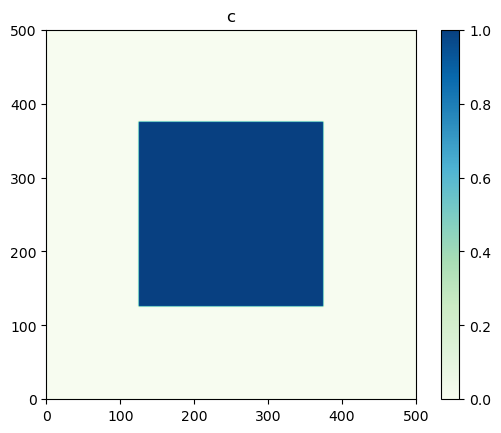

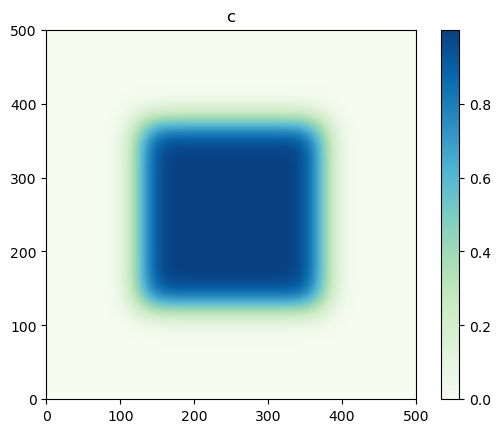

In [3]:
from MyDiffusionGPU import MyDiffusionClass

sim = MyDiffusionClass(dimensions=[500, 500])

#initialize non-array parameters
sim.set_framework("GPU_SERIAL") #"CPU_SERIAL" or "GPU_SERIAL"
sim.set_dt(0.1)
sim.set_save_path("data/diffusion_test")
sim.set_autosave_flag(True)
sim.set_autosave_save_images_flag(True)
sim.set_autosave_rate(2000)
sim.set_boundary_conditions("PERIODIC")

data = {
    "D":1.
}
sim.set_user_data(data)

#initialize simulation arrays, all parameter changes should be BEFORE this point!
sim.initialize_engine()

#change array data here, for custom simulations
"""
sim.fields[0].data[:] = 1.
length = sim.dimensions[0]
width = sim.dimensions[1]
sim.fields[0].data[length // 4:3 * length // 4, width // 4:3 * width // 4] = 0.
"""


#initial conditions
sim.plot_simulation()

#run simulation
sim.simulate(2000)

#final conditions
sim.plot_simulation()